# In this notebook page, the two models would be trained and be used to predict pictures.    
## In the Following parts, the two models, loss and accuracy curves, consusion matrix and interperting using captum would be shown.

In [2]:
%matplotlib inline

In [3]:
# import necessary packages
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import os
from torch.utils.data import random_split
import torchvision
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from PIL import Image

### Prepare work before training the model

1. show the number of dataset for trainin and testing. Such function is shown below. By doin this parts, users could see clearly how the dataset consists of and could use this when doing further analyse.

In [4]:
def show_number():
    picture_frames = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
    labels = picture_frames.iloc[:,1]
    labels = labels.to_list()
    x = set(labels)
    y = []
    for a in x:
        y.append(labels.count(a))
    x = list(x)
    plt.figure(figsize=(5, 4))
    plt.bar(x, y, facecolor='#1f77b4', edgecolor='k')
    # plt.xticks(rotation=90)
    plt.tick_params(labelsize=15)
    plt.xlabel('class', fontsize=10)
    plt.ylabel('number of data', fontsize=10)

2. create the dataset class to load the pictures in to RAM and change picture file into tensor. A parameter is added as it could create training
dataset and test dataset.

In [5]:
class CellPictureDataset(Dataset):

    def __init__(self, root_dir, csv_file=None, transform=None, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if csv_file is not None:
            self.data_frame = pd.read_csv(csv_file)
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.test is False:
            img_name = os.path.join(self.root_dir,
                                    self.data_frame.iloc[idx, 0])
        else:
            img_name = os.path.join(self.root_dir, os.listdir(self.root_dir)[idx])
        image = Image.open(img_name)
        if self.transform:
            self.image = self.transform(image)
        if self.test is False:
            label = self.data_frame.iloc[idx, 1]
            return self.image, label
        else:
            return self.image

3. design my own convnet. I generate it as a 4-layer convnet, and set the last one layer as a hyperparameter for further modifying.

In [6]:
import collections
class MyConvNet(nn.Module):
    def __init__(self, l1=120):
        super().__init__()
        self.model = nn.Sequential(collections.OrderedDict([
            ('conv1', nn.Conv2d(3,32,5,stride=5)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32,16,5,stride=2)),
            ('relu2', nn.ReLU()),
            # Put in a linear layers ...
            ('flatten', nn.Flatten()),                                          
            ('fc1', nn.Linear(80*80,l1)),
            ('relu3', nn.ReLU()),
            ('fc3', nn.Linear(l1,4)),
        ]))

    def forward(self, x):
        x = self.model(x)
        return x


4. visualize a batch. Before using the dataset to train the model, it is necessary to deal with the pictures. For example, it is a good way to 
reshaple the pictures into a same shape, which could improve the robustness of the model.

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_a_batch():

    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])
    train_dataset = CellPictureDataset('/kaggle/input/deep-learning-for-msc-2022-23/train', csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv', transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

    images, labels = next(iter(train_loader))

    images = images.numpy()

    n=6
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  # 类似绘制子图 subplot(111)
                    nrows_ncols=(n, n),  # 创建 n 行 m 列的 axes 网格
                    axes_pad=0.02,  # 网格间距
                    share_all=True
                    )

    # 遍历每张图像
    for ax, im in zip(grid, images):
        ax.imshow(im.transpose((1,2,0)))
        ax.axis('off')

#     plt.tight_layout()

## Using ray tune to modyfy hyperparameters    

### In this parts, the functions are used to modify the hyperparameters of the model. The benefits of modify such hyperparameters are, for example, preventing overfitting during training and, improve accuracy of the model.

1. training function for model_1

In [8]:
# the function for trianing model_1, in this function, set number of last connection layer nurons, learnin rate, monmentum, batch size as hyperparameter
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = MyConvNet(config["l1"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])

    csv_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
    train_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=train_transform)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader =DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2,
        pin_memory=True)

    for epoch in range(35):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            net.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
#             print(outputs.device)
            # if i % 100 == 99:  # print every 2000 mini-batches
            #     print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
            #                                     running_loss / epoch_steps))
            #     running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
#                 net.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
#     print("Finished Training")

2. training function for model_2. The used model is resnet18, which is the best choice from resnet50, vgg16, etc. Through testing, a complex model may be not suitable for this dataset. When used vgg16, the loss is even higher than model_1.

In [9]:
# # the function for trianing model_2, in this function, set learnin rate, monmentum as hyperparameter
def train_cifar_2(config, checkpoint_dir=None, data_dir=None):
    net = torchvision.models.resnet18()
    net.fc = nn.Linear(net.fc.in_features, 4)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    csv_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
    train_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=train_transform)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader =DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    valloader = DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2,
        pin_memory=True)

    for epoch in range(35):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            net.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
#             print(outputs.device)
            # if i % 100 == 99:  # print every 2000 mini-batches
            #     print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
            #                                     running_loss / epoch_steps))
            #     running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
#                 net.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

#         with tune.checkpoint_dir(epoch) as checkpoint_dir:
#             path = os.path.join(checkpoint_dir, "checkpoint")
#             torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

3. function for testing accuracy. It is necessary to split the training dataset as training parts and validation parts, which could test whether the model is overfitting or not. If plot the loss or accuracy curves, it can be seen that if as epoch iterating, the loss graudally decrease and accuracy increase, the model is heathy. If, for example, the training accuracy gradually increase, and even becomes nearly 100%, but the validation accuracy increase firstly and then decrease, it shows the model is overfitting.

In [10]:
def test_accuracy(net, device="cpu"):
    root_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train"
    csv_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"
    test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])
    trainset = CellPictureDataset(root_dir=root_dir, csv_file=csv_dir, transform=test_transform)
    testloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

4. using tune from ray to select the best model. Tune from is a package for modifying hyperparameters, it randomly set the hyperparameter from 'config', then doing the above functions. In this part, the complicated process would be omitted, as it is hard to show all the process in a notebook. Interval form the best model I have tried would be shown as an example.

In [11]:
# the interval for model_1 is in this function

def main_1(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    # train_dir = os.path.abspath("train")
    # load_data(train_dir)
    configs = {
#         "l1": tune.sample_from(lambda _: 2 ** np.random.randint(8, 10)),
        "l1": 256,
        "lr": tune.loguniform(0.00883, 0.00885),
#         "lr": 0.00105,
#         "batch_size": tune.choice([16, 32]),
        "batch_size": 16,
        "momentum": tune.loguniform(0.65, 0.68)
#         "momentum": 0.7
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        train_cifar,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=configs,
        num_samples=num_samples,
        scheduler=scheduler)
#         progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = MyConvNet(best_trial.config["l1"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

#     best_checkpoint_dir = best_trial.checkpoint.dir_or_data
#     model_state, optimizer_state = torch.load(os.path.join(
#         best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

In [12]:
# the interval for model_2 is in this function

def main_2(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    configs = {
        "l1": 0,
        "lr": tune.loguniform(0.001048, 0.001052),
#         "lr": 0.00105,
#         "batch_size": tune.choice([16, 32]),
        "batch_size": 32,
        "momentum": tune.loguniform(0.9779, 0.9782)
#         "momentum": 0.7
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        train_cifar_2,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=configs,
        num_samples=num_samples,
        scheduler=scheduler)
#         progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = MyConvNet(best_trial.config["l1"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

#     best_checkpoint_dir = best_trial.checkpoint.dir_or_data
#     model_state, optimizer_state = torch.load(os.path.join(
#         best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)

#     test_acc = test_accuracy(best_trained_model, device)
#     print("Best trial test set accuracy: {}".format(test_acc))

## Training the model

### After selecting suitable hyperparameters, it comes to training models. Whening training models, such functions like ploting the loss and accuracy curves could be added to test whether it is overfitting, as mentioned above.

1. code for ploting loss and accuracy curves. It will plot the training loss and validation loss for each epoch when training.

In [14]:
def training_and_visualize(model, learning_rate, momentum):
    epoch = 20

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)

    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])

    csv_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"
    data_transform = train_transform
    train_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=data_transform)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader =DataLoader(
        train_subset,
        batch_size=int(16),
        shuffle=True,
        num_workers=0)
    valloader = DataLoader(
        val_subset,
        batch_size=int(16),
        shuffle=True,
        num_workers=0)
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epoch):
        # train the model
        train_loss = 0.0
        train_acc = 0.0
        # total_train = 0
        # step_train = 0
        for i, data in enumerate(trainloader, 0):
            # ...
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            # total_train += labels.size(0)
            train_acc += (predicted == labels).sum().item() / len(labels)

        train_loss /= len(trainloader)
        train_acc /= len(trainloader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # validate the model
        val_loss = 0.0
        val_acc = 0.0
        # total = 0
        # correct = 0
        val_steps = 0
        with torch.no_grad():
            for i, data in enumerate(valloader, 0):
                with torch.no_grad():
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    # total += labels.size(0)
                    # correct += (predicted == labels).sum().item()

                    loss = loss_fn(outputs, labels)
                    val_loss += loss.cpu().numpy()
                    # val_loss += loss.item()
                    val_acc += (predicted == labels).sum().item() / len(labels)

        val_loss /= len(valloader)
        val_acc /= len(valloader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # plot the training and validation losses
    axs[0].plot(train_losses, label="Training Loss")
    axs[0].plot(val_losses, label="Validation Loss")
    axs[0].legend()
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")

    # plot the training and validation accuracies
    axs[1].plot(train_accs, label="Training Accuracy")
    axs[1].plot(val_accs, label="Validation Accuracy")
    axs[1].legend()
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")

2. Function for drawing confusion matrix. Confusion matrix is useful in machine learning and deep learning. It shows evaluaion standards beyond loss and accuracy, which is a good tool to analyse the model. In this part, a batch of dataset would be selected as an example to show the confusion matrix.

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def cnf_matrix_plotter(model, cmap=plt.cm.Blues):
    """
    import trained model, labels and colored map
    """
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    model.to(device)
    
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])
    train_dataset = CellPictureDataset('/kaggle/input/deep-learning-for-msc-2022-23/train', csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv', transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

    images, labels = next(iter(train_loader))
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)

    cm = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
    
    plt.figure(figsize=(4, 4))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() 
    tick_marks = np.arange(len(labels.numpy()))
    
    plt.title('confusion matrix', fontsize=30)
    plt.xlabel('predicted', fontsize=25, c='r')
    plt.ylabel('real class', fontsize=25, c='r')
    plt.tick_params(labelsize=12) # set font size

    # write numbers
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

#     plt.tight_layout()

    # plt.savefig('混淆矩阵.pdf', dpi=300) # save figures

## Interpertation for models

### After getting the models, we need to know how the models work, and analyse why the models generate such result. A necessary part is model interpretaion. In pytorch, the captum could be used for analysing how the model works. As an example, the occlusion and intergrated gradient are shown below.

In [16]:
!pip3 install captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:0000:010:01


1. Occlusion. Occlusion uses a block to cover a part of the picture to test whether this part contributes an important role for the predicted result. The size of block can be changed, when using a small block could not get a good result, it can be changed to a larger block. 

In [18]:
def doing_occulsion(model, img_pil):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    transform_A = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),          
        transforms.ToTensor()         
    ])
    transform_B = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    model.eval().to(device)
    rc_img = transform_A(img_pil)
    rc_img_norm = np.transpose(rc_img.squeeze().cpu().detach().numpy(), (1,2,0))
    input_tensor = transform_B(rc_img).unsqueeze(0).to(device)
    pred_logits = model(input_tensor)
    pred_softmax = F.softmax(pred_logits, dim=1)
    pred_conf, pred_id = torch.topk(pred_softmax, 1)
    pred_conf = pred_conf.detach().cpu().numpy().squeeze().item()
    pred_id = pred_id.detach().cpu().numpy().squeeze().item()
    
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input_tensor,
                                       strides = (3, 8, 8), # 遮挡滑动移动步长
                                       target=pred_id, # 目标类别
                                       sliding_window_shapes=(3, 15, 15), # 遮挡滑块尺寸
                                       baselines=0) # 被遮挡滑块覆盖的像素值
    attributions_occ_norm = np.transpose(attributions_occ.detach().cpu().squeeze().numpy(), (1,2,0))
    viz.visualize_image_attr_multiple(attributions_occ_norm, # 224 224 3
                                  rc_img_norm,           # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  show_colorbar=True,
                                  outlier_perc=2)

2. Intergrated gradients
Intergrated gradients shows the process of a pixel from 0 to its original value in intergrated gradient. This can conclude the importance of each pixel for the prediction.

In [19]:
def doing_ig(model, img_pil):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    transform_A = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),          
        transforms.ToTensor()         
    ])
    transform_B = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    model.eval().to(device)
    rc_img = transform_A(img_pil)
    rc_img_norm = np.transpose(rc_img.squeeze().cpu().detach().numpy(), (1,2,0))
    input_tensor = transform_B(rc_img).unsqueeze(0).to(device)
    pred_logits = model(input_tensor)
    pred_softmax = F.softmax(pred_logits, dim=1)
    pred_conf, pred_id = torch.topk(pred_softmax, 1)
    pred_conf = pred_conf.detach().cpu().numpy().squeeze().item()
    pred_id = pred_id.detach().cpu().numpy().squeeze().item()
    
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input_tensor, target=pred_id, n_steps=200)
    attributions_ig_norm = np.transpose(attributions_ig.detach().cpu().squeeze().numpy(), (1,2,0))
    plt.imshow(attributions_ig_norm[:, :, 0] * 100)

    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

# 可视化 IG 值
    viz.visualize_image_attr(attributions_ig_norm, # 224,224,3
                            rc_img_norm,          # 224,224,3
                            method='heat_map',
                            cmap=default_cmap,
                            show_colorbar=True,
                            sign='positive',
                            outlier_perc=1)
    
    # add noise to make the figure smooth
    noise_tunnel = NoiseTunnel(integrated_gradients) 

    # 获得输入图像每个像素的 IG 值
    attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_samples=2, nt_type='smoothgrad_sq', target=pred_id)

    # 转为 224 x 224 x 3的数据维度
    attributions_ig_nt_norm = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))

    # 设置配色方案
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                    [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

    viz.visualize_image_attr_multiple(attributions_ig_nt_norm, # 224 224 3
                                    rc_img_norm, # 224 224 3
                                    ["original_image", "heat_map"],
                                    ["all", "positive"],
                                    cmap=default_cmap,
                                    show_colorbar=True)

## Other transition functions

In [20]:
# get and save model_1 to a lcoal .pth file
def get_best_model1(lr, monmentum, l1):
    # total_train_step = 0
    # total_test_step = 0
    model = MyConvNet(l1=l1)
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(model)
    model.to(device)

    # data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
    csv_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"
    data_transform = train_transform
    train_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=data_transform)
    train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
    epoch = 35
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=monmentum)
    for i in range(epoch):
        # print("-------no.{} train begin".format(i+1))
        for data in train_loader:
            image, label = data
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = loss_fn(outputs, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    torch.save(model, 'myconvnet.pth')
    return model

In [21]:
# get and save model_2 to a local .pth file
def get_best_model2(lr, monmentum):

    model = torchvision.models.resnet18()   
    model.fc = nn.Linear(model.fc.in_features, 4)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
    
    csv_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train.csv"
    data_transform = train_transform
    train_dir = "/kaggle/input/deep-learning-for-msc-2022-23/train"
    trainset = CellPictureDataset(train_dir, csv_file=csv_dir, transform=data_transform)
    train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    epoch = 35
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=monmentum)
    for i in range(epoch):
        print("-------no.{} train begin".format(i+1))
        for data in train_loader:
            image, label = data
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = loss_fn(outputs, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    torch.save(model, 'resnet18.pth')
    return model

In [23]:
# output the target .cvs result file
def get_result(model, filepath):
    test_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(
                                             mean=[0.485, 0.456, 0.406], 
                                             std=[0.229, 0.224, 0.225])
                                        ])
    testset = CellPictureDataset("/kaggle/input/deep-learning-for-msc-2022-23/test",transform=test_transform, test=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    model.eval().to(device)

    labels = []
    for data in testloader:
            image = data.to(device)
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
            label_list = list(predicted.cpu().numpy())
            for label in label_list:
                 labels.append(label)
    data_frame = {'Filename': os.listdir('/kaggle/input/deep-learning-for-msc-2022-23/test'),
                  'Label': labels
                  }
    df = pd.DataFrame(data_frame)
    df.to_csv(filepath, index=False)

In [90]:
main_1(num_samples=10, max_num_epochs=35, gpus_per_trial=2)

(train_cifar pid=391813) E0326 20:50:33.760725498  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar_c44f6_00000,0.842593,2023-03-26_21-07-09,True,,6a7374f98af4499587ba3d897b28c8e7,ffbb417b3e5c,35,0.401539,172.19.2.2,391813,1026.33,29.6597,1026.33,1679864829,0,,35,c44f6_00000,0.00567508
train_cifar_c44f6_00001,0.76918,2023-03-26_21-07-51,True,,816b3360b1ff40b380d4a31d75aa704b,ffbb417b3e5c,1,0.641766,172.19.2.2,427376,36.5249,36.5249,36.5249,1679864871,0,,1,c44f6_00001,0.00969768
train_cifar_c44f6_00002,0.705688,2023-03-26_21-08-34,True,,b4dd7fb235e043af9bcb4de69d03b579,ffbb417b3e5c,1,0.743693,172.19.2.2,428447,36.9576,36.9576,36.9576,1679864914,0,,1,c44f6_00002,0.0194054
train_cifar_c44f6_00003,0.758598,2023-03-26_21-09-16,True,,23f125c453f8408dbf7bb44a780ee649,ffbb417b3e5c,1,0.672159,172.19.2.2,429519,36.3672,36.3672,36.3672,1679864956,0,,1,c44f6_00003,0.00489855
train_cifar_c44f6_00004,0.636243,2023-03-26_21-09-58,True,,0cbb676d47dc408186162e3f637a73dd,ffbb417b3e5c,1,0.909792,172.19.2.2,430575,36.3144,36.3144,36.3144,1679864998,0,,1,c44f6_00004,0.00555396
train_cifar_c44f6_00005,0.684524,2023-03-26_21-10-41,True,,519b09d33d4b43c2bc7620b656edbf24,ffbb417b3e5c,1,0.758639,172.19.2.2,431659,36.148,36.148,36.148,1679865041,0,,1,c44f6_00005,0.00888968
train_cifar_c44f6_00006,0.759259,2023-03-26_21-12-50,True,,1c393293869f45caa36cd6021fc80f9c,ffbb417b3e5c,4,0.599625,172.19.2.2,432730,123.732,29.0943,123.732,1679865170,0,,4,c44f6_00006,0.0124922
train_cifar_c44f6_00007,0.818783,2023-03-26_21-20-50,True,,62973bc6e70045b9958b4ceea96a02ac,ffbb417b3e5c,16,0.457497,172.19.2.2,436850,474.245,29.0498,474.245,1679865650,0,,16,c44f6_00007,0.00515723
train_cifar_c44f6_00008,0.748016,2023-03-26_21-22-01,True,,1eb386af07594a54bdec5971d606f184,ffbb417b3e5c,2,0.714428,172.19.2.2,453143,65.127,29.0863,65.127,1679865721,0,,2,c44f6_00008,0.00573564
train_cifar_c44f6_00009,0.722222,2023-03-26_21-22-43,True,,30dc4879def04cf9b1a567a8d331d100,ffbb417b3e5c,1,0.746719,172.19.2.2,455234,36.6279,36.6279,36.6279,1679865763,0,,1,c44f6_00009,0.00522137


(train_cifar pid=391813) E0326 20:51:02.641525566  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar pid=391813) E0326 20:51:08.021026346  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar pid=391813) E0326 20:52:28.854840127  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar pid=391813) E0326 20:52:35.028570217  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar pid=391813) E0326 20:53:26.318929736  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar pid=391813) E0326 20:54:00.831817616  391853 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar pid=391813) E0326 20:54:00.880455397  3

Best trial config: {'l1': 256, 'lr': 0.008834116015646976, 'batch_size': 16, 'momentum': 0.6734565181609597}
Best trial final validation loss: 0.4015385495988946
Best trial final validation accuracy: 0.8425925925925926


E0326 21:22:43.488451004      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0326 21:22:43.597747214      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Best trial test set accuracy: 0.19854497354497355


In [13]:
main_2(num_samples=10, max_num_epochs=35, gpus_per_trial=2)

2023-03-27 08:28:23,403	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0327 08:28:26.400814073      24 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(train_cifar_2 pid=388) E0327 08:28:37.390920247     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:29:28.133235763     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar_2_58737_00000,0.921296,2023-03-27_08-48-37,True,,01c0177fdac54c77b7b5a17c47388ac8,a78dd7007caa,35,0.234739,172.19.2.2,388,1205.12,33.276,1205.12,1679906917,0,,35,58737_00000,0.00578332
train_cifar_2_58737_00001,0.792328,2023-03-27_08-49-24,True,,8c2dc09a8f1247828e2496303fc44b47,a78dd7007caa,1,0.617233,172.19.2.2,19593,41.872,41.872,41.872,1679906964,0,,1,58737_00001,0.00497031
train_cifar_2_58737_00002,0.778439,2023-03-27_08-50-11,True,,c2f5d779a3e640c89fac1bcc8a07f56e,a78dd7007caa,1,0.595628,172.19.2.2,20200,40.5003,40.5003,40.5003,1679907011,0,,1,58737_00002,0.00452137
train_cifar_2_58737_00003,0.771164,2023-03-27_08-50-57,True,,9436a15a53144feba9e85c1a63f86bc2,a78dd7007caa,1,0.671766,172.19.2.2,20804,41.65,41.65,41.65,1679907057,0,,1,58737_00003,0.00473619
train_cifar_2_58737_00004,0.81746,2023-03-27_08-52-20,True,,b29bbf48f4a0463fa8ca6ac747f25129,a78dd7007caa,2,0.495507,172.19.2.2,21416,77.4,35.2571,77.4,1679907140,0,,2,58737_00004,0.00686383
train_cifar_2_58737_00005,0.693122,2023-03-27_08-53-07,True,,b7244b91447149ffbb34e17e94f6f262,a78dd7007caa,1,0.76395,172.19.2.2,22568,41.3089,41.3089,41.3089,1679907187,0,,1,58737_00005,0.00445056
train_cifar_2_58737_00006,0.812169,2023-03-27_08-54-30,True,,af72cbe369e54b9690d3827e2001ea3f,a78dd7007caa,2,0.478621,172.19.2.2,23179,77.0563,35.3864,77.0563,1679907270,0,,2,58737_00006,0.00464845
train_cifar_2_58737_00007,0.800926,2023-03-27_08-55-50,True,,5b1d04629078460ba7e34be6326269ea,a78dd7007caa,2,0.506957,172.19.2.2,24328,74.372,33.1822,74.372,1679907350,0,,2,58737_00007,0.00597119
train_cifar_2_58737_00008,0.76918,2023-03-27_08-56-36,True,,339994f5c3fa4a0e957107d9eb62dfa7,a78dd7007caa,1,0.600909,172.19.2.2,25483,40.564,40.564,40.564,1679907396,0,,1,58737_00008,0.00470161
train_cifar_2_58737_00009,0.806878,2023-03-27_08-57-56,True,,7134f44ff99b4482b68f3d4be50f754c,a78dd7007caa,2,0.495292,172.19.2.2,26087,74.8051,32.9953,74.8051,1679907476,0,,2,58737_00009,0.0042603


(train_cifar_2 pid=388) E0327 08:29:37.853982577     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:30:39.195652012     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:32:54.783955330     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:33:28.710419711     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:34:08.698582349     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:36:50.444783121     424 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_cifar_2 pid=388) E0327 08:36:56.131021050     424 f

Best trial config: {'l1': 0, 'lr': 0.001049767863664666, 'batch_size': 32, 'momentum': 0.9781250795948682}
Best trial final validation loss: 0.2347394578779737
Best trial final validation accuracy: 0.9212962962962963


NameError: name 'test_acc' is not defined

## Here are some results done before   
### Model 1:   
Best trial config: {'l1': 256, 'lr': 0.008830556690188944, 'batch_size': 16, 'momentum': 0.6994160916279658}   
Best trial final validation loss: 0.3116818554699421   
Best trial final validation accuracy: 0.8888888888888888   

Best trial config: {'l1': 256, 'lr': 0.008496887554385796, 'batch_size': 16, 'momentum': 0.7}   
Best trial final validation loss: 0.41590764350012727   
Best trial final validation accuracy: 0.8313492063492064   

Best trial config: {'l1': 256, 'lr': 0.008400433060204328, 'batch_size': 16, 'momentum': 0.7}   
Best trial final validation loss: 0.3691868227563406   
Best trial final validation accuracy: 0.8525132275132276   

Best trial config: {'l1': 256, 'lr': 0.008846023814771488, 'batch_size': 16, 'momentum': 0.6758279554899572}   
Best trial final validation loss: 0.370411437436154   
Best trial final validation accuracy: 0.8677248677248677   

### Model 2:   
Best trial config: {'l1': 256, 'lr': 0.0022188691790772626, 'batch_size': 32, 'momentum': 0.9}   
Best trial final validation loss: 0.33351144722352427   
Best trial final validation accuracy: 0.8783068783068783   

Best trial config: {'l1': 256, 'lr': 0.004116054161126479, 'batch_size': 32, 'momentum': 0.9}   
Best trial final validation loss: 0.3017727502932151   
Best trial final validation accuracy: 0.8816137566137566   

Best trial config: {'l1': 256, 'lr': 0.004109638954506841, 'batch_size': 32, 'momentum': 0.9}   
Best trial final validation loss: 0.28804489174702513   
Best trial final validation accuracy: 0.8941798941798942   

Best trial config: {'l1': 256, 'lr': 0.004109638954506841, 'batch_size': 32, 'momentum': 0.9374381166958563}   
Best trial final validation loss: 0.23609109207366905   
Best trial final validation accuracy: 0.9186507936507936   

Best trial config: {'l1': 128, 'lr': 0.0015, 'batch_size': 32, 'momentum': 0.9784381166958563}   
Best trial final validation loss: 0.23121472005732358   
Best trial final validation accuracy: 0.9166666666666666   

Best trial config: {'l1': 256, 'lr': 0.0010422197412194802, 'batch_size': 32, 'momentum': 0.978}   
Best trial final validation loss: 0.26567449249948066   
Best trial final validation accuracy: 0.9120370370370371

In [24]:
net_1 = get_best_model1(lr= 0.008830556690188944, monmentum= 0.6994160916279658, l1=256)
# net_1 = torch.load("/kaggle/working/myconvnet.pth")
net_2 = get_best_model2(lr= 0.00105, monmentum= 0.978)
# net_2 = torch.load("/kaggle/working/resnet18.pth")

-------no.1 train begin
-------no.2 train begin
-------no.3 train begin
-------no.4 train begin
-------no.5 train begin
-------no.6 train begin
-------no.7 train begin
-------no.8 train begin
-------no.9 train begin
-------no.10 train begin
-------no.11 train begin
-------no.12 train begin
-------no.13 train begin
-------no.14 train begin
-------no.15 train begin
-------no.16 train begin
-------no.17 train begin
-------no.18 train begin
-------no.19 train begin
-------no.20 train begin
-------no.21 train begin
-------no.22 train begin
-------no.23 train begin
-------no.24 train begin
-------no.25 train begin
-------no.26 train begin
-------no.27 train begin
-------no.28 train begin
-------no.29 train begin
-------no.30 train begin
-------no.31 train begin
-------no.32 train begin
-------no.33 train begin
-------no.34 train begin
-------no.35 train begin


this block shows number of each class and a batch of being transformed pictures

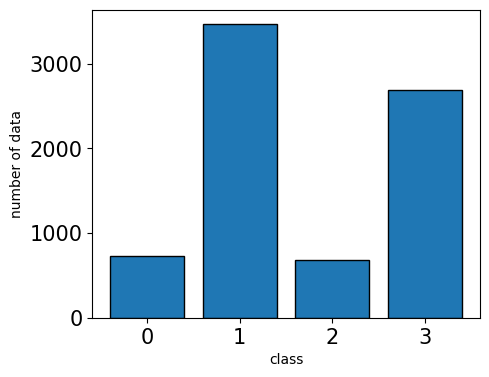

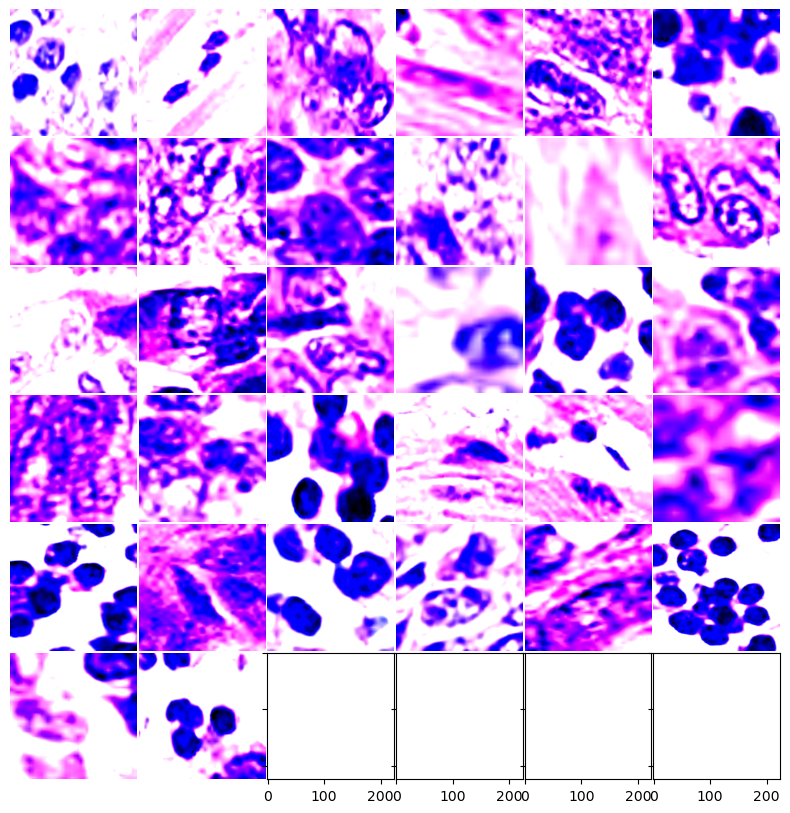

In [26]:
show_number()
show_a_batch()

this block shows the trianin process of the chosen 'best' model_1 and model_2. From the plots, we can see that the training process it not overfitting.

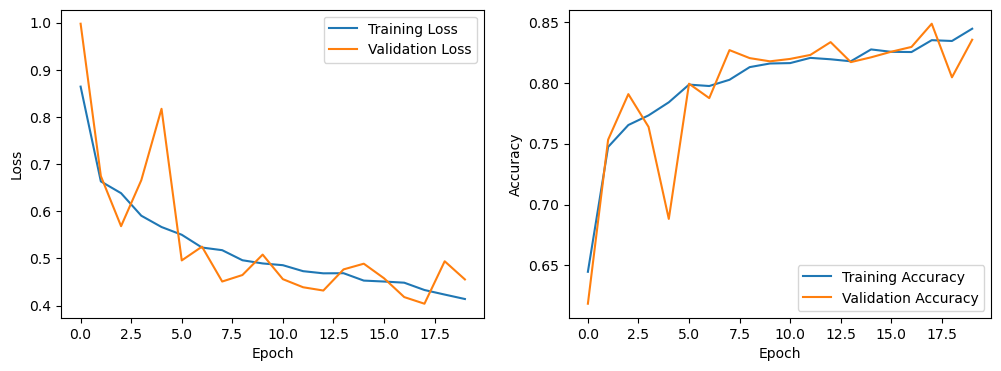

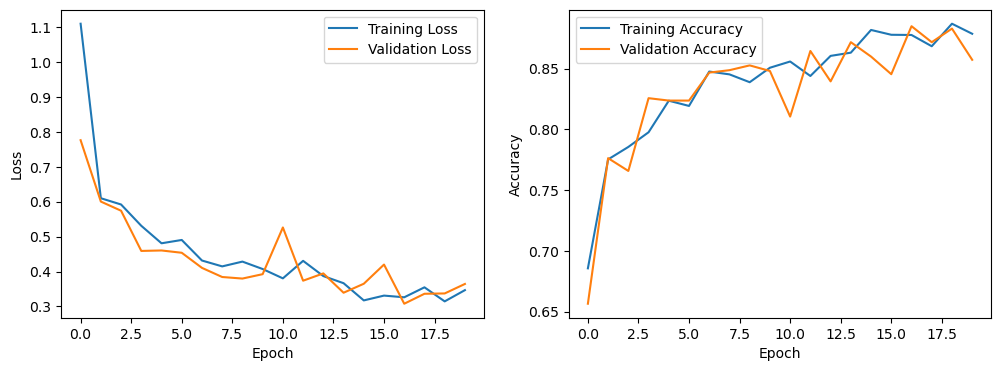

In [27]:
training_and_visualize(MyConvNet(l1=256), learning_rate=0.008830556690188944, momentum=0.6994160916279658)
training_and_visualize(torchvision.models.resnet18(), learning_rate=0.00105, momentum=0.978)
    

this block shows the confusion matrix. Using a batch as an example, we can see that model_1 has a better abilitity of classifying class 1 and class 3, but with some errors for class 0 and class 2. This may due to that the portion of the data as the number of pictures for class 0 and class 2 are small. While model_2 has such ability for classifying. If enlarge the dataset, the result may be better.

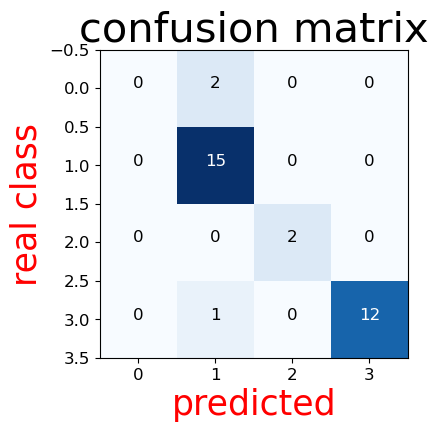

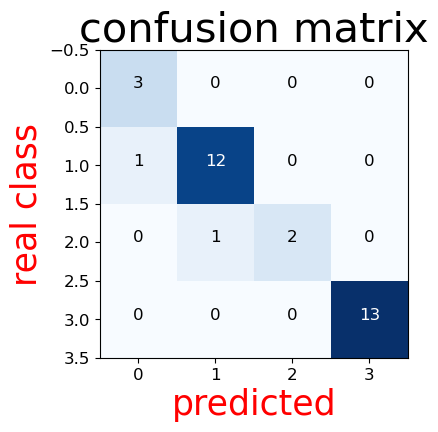

In [28]:
cnf_matrix_plotter(net_1) # create confusion matrix for model_1
cnf_matrix_plotter(net_2) # create confusion matrix for model_2

this parts randomly choose a picture from train dataset and analyse how the models works on it.

In [29]:
# randomly select a picture from train dataset
img_path = "/kaggle/input/deep-learning-for-msc-2022-23/train/7.png"
img_pil = Image.open(img_path)

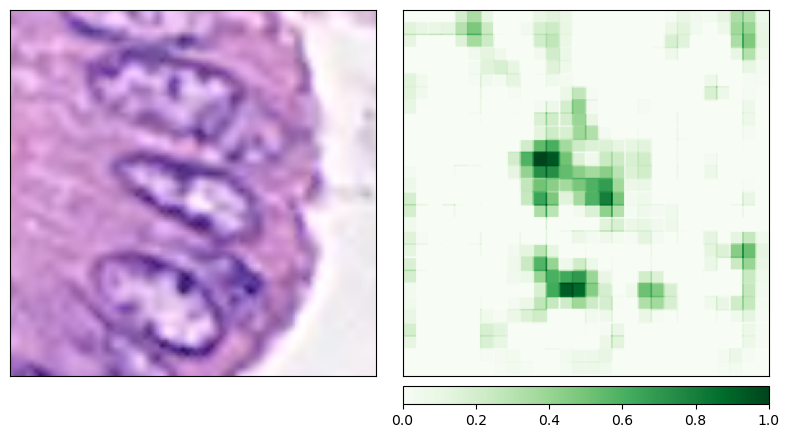

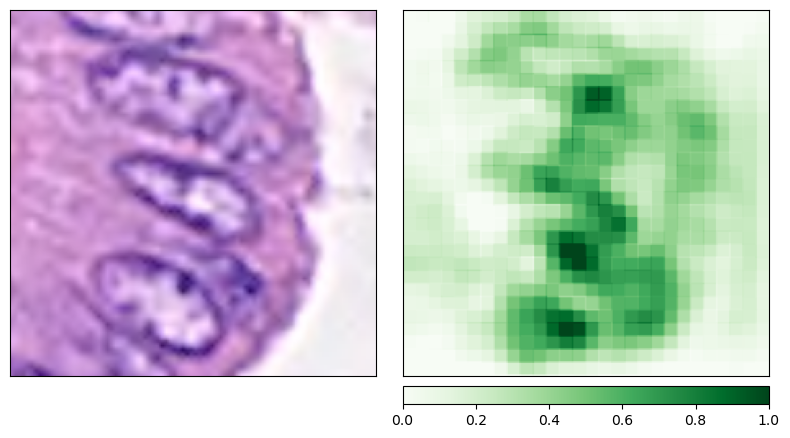

In [30]:
doing_occulsion(net_1, img_pil=img_pil) 
doing_occulsion(net_2, img_pil=img_pil) 

from that, we can see that model_2 recognize a larger region of blocks for classifying.

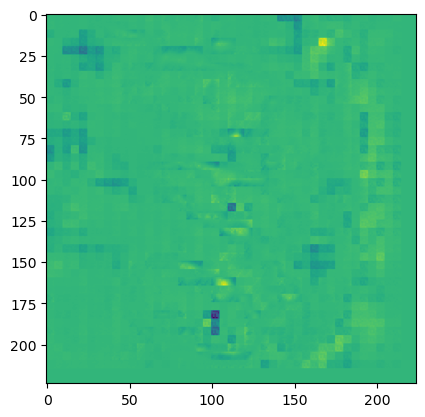

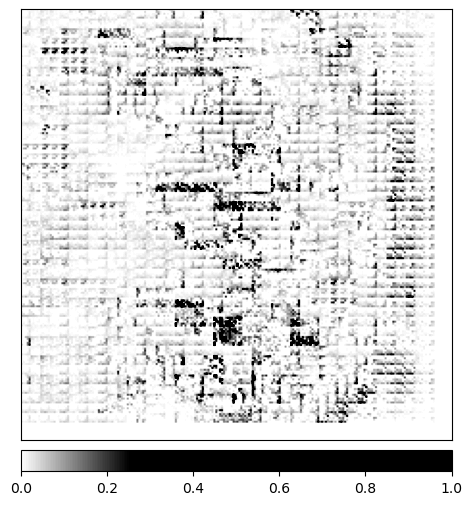

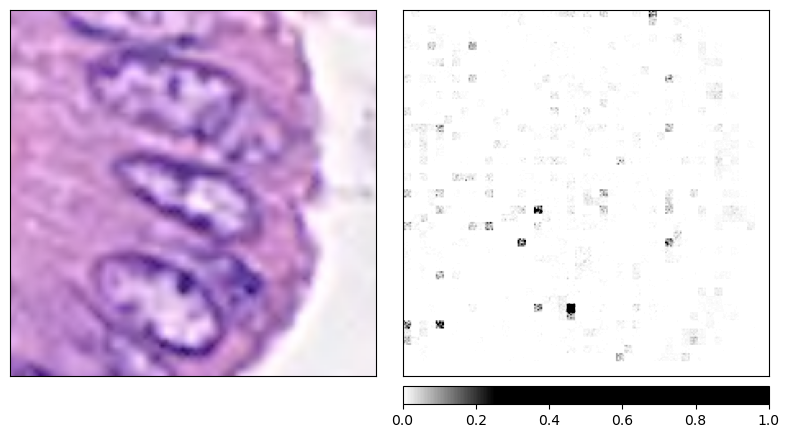

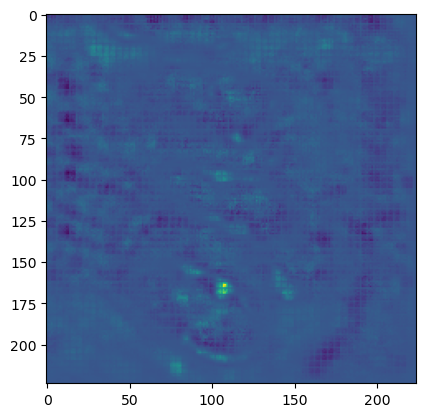

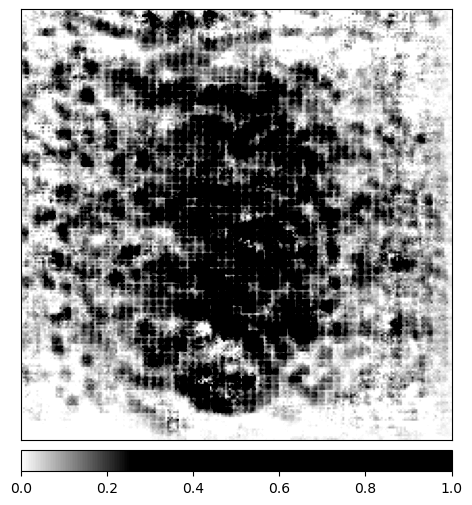

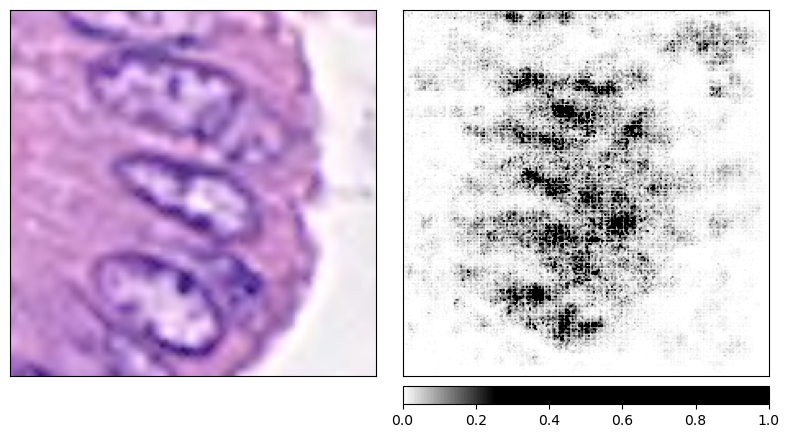

In [31]:
doing_ig(net_1, img_pil=img_pil)
doing_ig(net_2, img_pil=img_pil)

From that, we can see that model_1 can recognize a smaller regions than model_2. That may due to the complexity of the model. As the model_1 is just only 4 layers, it would drop some features of the pictures. Model_2 can recognize the nucleus better than model_1.

In [32]:
get_result(net_1, 'result_from_model1.csv')
get_result(net_2, 'result_from_model2.csv')

get the .csv result